## Test model

In [7]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import segmentation_models as sm
import albumentations as A
import skimage
from skimage import io, img_as_ubyte, measure
from tensorflow import keras
import keras
from shapely.geometry import Polygon
import tqdm
import json
tf.__version__

'2.3.1'

In [11]:
# check JSON submission format

import json
import uuid
from IPython.core.display import display, HTML

class RenderJSON(object):
    def __init__(self, json_data):
        if isinstance(json_data, dict):
            self.json_str = json.dumps(json_data)
        else:
            self.json_str = json_data
        self.uuid = str(uuid.uuid4())
        # This line is missed out in most of the versions of this script across the web, it is essential for this to work interleaved with print statements
        #self._ipython_display_()
        
    def _ipython_display_(self):
        display(HTML('<div id="{}" style="height: auto; width:100%;"></div>'.format(self.uuid)))
        display(HTML("""<script>
        require(["https://rawgit.com/caldwell/renderjson/master/renderjson.js"], function() {
          renderjson.set_show_to_level(1)
          document.getElementById('%s').appendChild(renderjson(%s))
        });</script>
        """ % (self.uuid, self.json_str)))

with open('../inference/coco_test.json') as f:
    example = json.load(f)

RenderJSON(example)

In [14]:
# helper functions

def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

def threshold_image(image, threshold=128):
    # grab the image dimensions
    h = image.shape[0]
    w = image.shape[1]
    thresholded_image = image.copy()
    # loop over the image, pixel by pixel
    for y in range(0, h):
        for x in range(0, w):
            # threshold the pixel
            thresholded_image[y, x] = 255 if image[y, x] >= threshold else 0     
    # return the thresholded image
    return thresholded_image

json_template = {"categories":[{"Supercategory": "none",
                                  "name": "People",
                                  "id": 1},
                                 {"Supercategory": "none",
                                  "name": "Mixer_truck",
                                  "id": 2},
                                 {"Supercategory": "none",
                                  "name": "Vertical_formwork",
                                  "id": 3},
                                 {"Supercategory": "none",
                                  "name": "Concrete_pump_hose",
                                  "id": 4}],
                  "info": {"description": "Chronsite test dataset - Group 6",
                           "year": 2020},
                  "licenses": []}
                  
images_template = {"images": [{"file_name": "xx.jpg",
                              "id": 33,
                              "height": 1024,
                              "width": 1280}]}

annotations_template = {'area': 5040,
                        'bbox': [980, 696, 60, 84],
                        'category_id': 3,
                        'id': 630,
                        'image_id': 33,
                        'iscrowd': 0,
                        'segmentation': [[990, 700, 1007, 696]]}

In [3]:
# load model
model = keras.models.load_model('models/best_model_0510.h5', compile=False)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 4 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 4 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 4 0           stem_bn[0][0]                    
____________________________________________________________________________________________

### Individual image pipeline

In [4]:
# read image
image = '/Users/Thomas/Desktop/app/static/Batch2__BioSAV_BIofiltration_18mois_05frame3389.jpg'
image_id = os.path.basename(image)
image = skimage.io.imread(image, plugin='matplotlib')
HEIGHT = image.shape[0]
WIDTH = image.shape[1]
image_info = {"file_name": image_id, "id": image_id, "height": HEIGHT, "width": WIDTH}

In [5]:
# preprocess image
if image.shape[-1] == 4: # remove alpha channel
    image = image[..., :3]
BACKBONE = 'efficientnetb3'
preprocess_input = sm.get_preprocessing(BACKBONE)
resize_preprocess_transform = A.Compose([
    #A.PadIfNeeded(768, 1024, p=1.0, border_mode=0),
    A.Resize(height=768, width=1024, p=1.0),
    A.Lambda(image=preprocess_input)])
resized_preprocessed = resize_preprocess_transform(image=image)
image = resized_preprocessed["image"]
image = np.expand_dims(image, axis=0)

In [6]:
# predict masks
pr_mask = model.predict(image)

In [7]:
# post-processing step 1: resize
pr_mask = pr_mask.squeeze()
image = denormalize(image).squeeze()
inverse_resize_transform = A.Compose([
    #A.PadIfNeeded(HEIGHT, WIDTH, p=1.0, border_mode=0),
    A.Resize(height=HEIGHT, width=WIDTH, p=1.0)])
inverse_resized = inverse_resize_transform(image=image, mask=pr_mask)
image, pr_mask = inverse_resized["image"], inverse_resized["mask"]

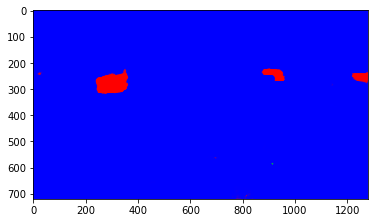

In [8]:
plt.imshow(pr_mask)

In [9]:
# check pixel values in channels of the predicted mask
unique, counts = np.unique(img_as_ubyte(pr_mask[...,0]), return_counts=True)
print(dict(zip(unique, counts)))

{0: 893708, 1: 8947, 2: 1777, 3: 747, 4: 480, 5: 353, 6: 259, 7: 198, 8: 143, 9: 121, 10: 103, 11: 117, 12: 95, 13: 93, 14: 62, 15: 63, 16: 62, 17: 60, 18: 51, 19: 51, 20: 38, 21: 34, 22: 49, 23: 56, 24: 32, 25: 31, 26: 30, 27: 37, 28: 32, 29: 28, 30: 27, 31: 22, 32: 31, 33: 26, 34: 23, 35: 18, 36: 19, 37: 26, 38: 16, 39: 14, 40: 17, 41: 19, 42: 19, 43: 16, 44: 11, 45: 15, 46: 16, 47: 17, 48: 17, 49: 16, 50: 15, 51: 16, 52: 21, 53: 10, 54: 26, 55: 4, 56: 8, 57: 17, 58: 14, 59: 3, 60: 8, 61: 6, 62: 18, 63: 9, 64: 13, 65: 15, 66: 14, 67: 13, 68: 12, 69: 5, 70: 9, 71: 6, 72: 5, 73: 15, 74: 8, 75: 15, 76: 9, 77: 10, 78: 11, 79: 13, 80: 11, 81: 10, 82: 6, 83: 14, 84: 15, 85: 8, 86: 5, 87: 11, 88: 8, 89: 12, 90: 10, 91: 9, 92: 10, 93: 11, 94: 9, 95: 6, 96: 10, 97: 7, 98: 8, 99: 12, 100: 5, 101: 13, 102: 3, 103: 8, 104: 6, 105: 7, 106: 15, 107: 1, 108: 5, 109: 5, 110: 9, 111: 12, 112: 6, 113: 5, 114: 6, 115: 7, 116: 7, 117: 5, 118: 4, 119: 14, 120: 10, 121: 7, 122: 8, 123: 10, 124: 7, 125: 10

In [10]:
# post-processing step 2: threshold
T = 204
formworks = threshold_image(img_as_ubyte(pr_mask[...,0]), threshold = T)
pumps = threshold_image(img_as_ubyte(pr_mask[...,1]), threshold = T)

In [11]:
unique, counts = np.unique(formworks, return_counts=True)
print(dict(zip(unique, counts)))

{0: 909685, 255: 11915}


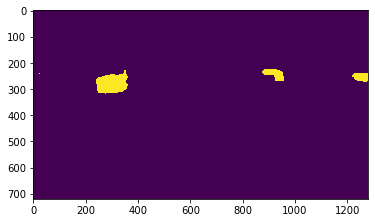

In [12]:
plt.imshow(formworks);

In [66]:
# post-processing step 3: find contours
contours_formworks = measure.find_contours(formworks, 1)
contours_pumps = measure.find_contours(pumps, 1)
#contours_formworks = [x.round(0).tolist() for x in np.array(contours_formworks)]
#contours_pumps = [x.round(0).tolist() for x in np.array(contours_pumps)]

In [138]:
# post-processing step 4: format annotations
annotations = []
for idx, contour in enumerate(contours_formworks + contours_pumps):
    poly = Polygon(contour)
    if poly.area < 300: # very few ground truth formworks & pumps are <300px area
        continue
    #_, concave_hull_coords = alpha_shape(poly, alpha=0.01)
    poly = poly.simplify(3.0, preserve_topology=False)
    category_id = 3 if contour in contours_formworks else 4
    x, y, max_x, max_y = poly.bounds
    width = max_x - x
    height = max_y - y
    bbox = np.array([x, y, width, height]).round(0).tolist() # COCO format
    segmentation = np.array(poly.exterior.coords).ravel().round(0).tolist()
    #segmentation = list(set(segmentation)) # remove duplicated coordinate tuples
    annotation = {"area": poly.area, "image_id": image_id, "iscrowd": 0, 'id':idx+1,
                  "category_id": category_id, "bbox": bbox, "segmentation": segmentation}
    annotations.append(annotation)

In [ ]:
# save as JSON
pr_polygons = json_template
pr_polygons['annotations'] = annotations
with open('pr_polygons.json', 'w') as f:
    json.dump(pr_polygons, f)

### Full test set pipeline

In [13]:
# load test dataset images
test_dir = '/Users/Thomas/Desktop/app/data/Detection_Test_Set_Img'
test_ids = os.listdir(test_dir)

In [16]:
#### FULL TESTING PIPELINE ####

images = []
annotations = []
for i, image_id in enumerate(test_ids):
    
    # read image
    image = skimage.io.imread(os.path.join(test_dir, image_id), plugin='matplotlib')
    HEIGHT = image.shape[0]
    WIDTH = image.shape[1]
    image_info = {"file_name": os.path.join('img/', image_id), "id": i+1, 
                  "height": HEIGHT, "width": WIDTH}
    images.append(image_info)
    
    # preprocess image
    BACKBONE = 'efficientnetb3'
    preprocess_input = sm.get_preprocessing(BACKBONE)
    resize_preprocess_transform = A.Compose([
        A.Resize(height=768, width=1024, p=1.0),
        A.Lambda(image=preprocess_input)])
    resized_preprocessed = resize_preprocess_transform(image=image)
    image = resized_preprocessed["image"]
    image = np.expand_dims(image, axis=0)
    
    # predict masks
    pr_mask = model.predict(image)
    
    # post-processing step 1: resize
    pr_mask = pr_mask.squeeze()
    image = denormalize(image).squeeze()
    inverse_resize_transform = A.Compose([
        A.Resize(height=HEIGHT, width=WIDTH, p=1.0)])
    inverse_resized = inverse_resize_transform(image=image, mask=pr_mask)
    image, pr_mask = inverse_resized["image"], inverse_resized["mask"]
    
    # post-processing step 2: threshold
    T = 204
    formworks = threshold_image(img_as_ubyte(pr_mask[...,0]), threshold = T)
    pumps = threshold_image(img_as_ubyte(pr_mask[...,1]), threshold = T)
    
    # post-processing step 3: find contours
    contours_formworks = measure.find_contours(formworks, 1)
    contours_pumps = measure.find_contours(pumps, 1)
    contours_formworks = [x.round(0).tolist() for x in np.array(contours_formworks)]
    contours_pumps = [x.round(0).tolist() for x in np.array(contours_pumps)]
    
    # post-processing step 4: format annotations
    for idx, contour in enumerate(contours_formworks + contours_pumps):
        poly = Polygon(contour)
        if poly.area < 300: # very few ground truth formworks & pumps are <300px area
            continue
        #_, concave_hull_coords = alpha_shape(poly, alpha=0.01)
        poly = poly.simplify(3.0, preserve_topology=False)
        category_id = 3 if contour in contours_formworks else 4
        x, y, max_x, max_y = poly.bounds
        width = max_x - x
        height = max_y - y
        bbox = np.array([x, y, width, height]).round(0).tolist() # COCO format
        segmentation = np.array(poly.exterior.coords).ravel().round(0).tolist()
        #segmentation = list(set(segmentation)) # remove duplicated coordinate tuples
        annotation = {"area": poly.area, "file_name":os.path.join('img/', image_id),
                      "image_id": i+1, "iscrowd": 0, 'id':idx+1, "category_id": category_id,
                      "bbox": bbox, "segmentation": segmentation}
        annotations.append(annotation)
    
    # print counter
    print(f'\r{i+1}/{len(test_ids)}', end='')

100/100

In [8]:
# save as JSON
pr_polygons = json_template
pr_polygons['annotations'] = annotations
pr_polygons['images'] = images
with open('submission_segm.json', 'w') as f:
    json.dump(pr_polygons, f)

In [12]:
with open('submission_segm.json') as f:
    verify = json.load(f)

RenderJSON(verify)